In [ ]:
from pathlib import Path
 
import numpy as np
import pandas as pd
 
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
from imblearn.over_sampling import SMOTE
 
 
import xgboost as xgb
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,roc_auc_score#metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate,cross_val_predict,GridSearchCV   #Additional scklearn functions
 
from xgboost import XGBClassifier
import lightgbm as lgb
 
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline
plt.style.use('seaborn-whitegrid')
 
pd.set_option("display.max_columns", 100)
 
target, IDcol='label_correct', 'tripid'

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/Data/train_gd.csv",
    index_col='tripid'
)
df_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/Data/test_gd.csv",
    index_col='tripid'
)

In [ ]:
# train_df['diffdis'] = np.where(train_df['pd'] == train_df['dd'], 0, 1)
# df_test['diffdis'] = np.where(df_test['pd'] == df_test['dd'], 0, 1)

# train_df = train_df.drop(columns=['dd'])
#features_df = pd.get_dummies(features_df, columns=['age_group'])

In [ ]:


# def sqdistance(datasetrow):
#     dis = geopy.distance.distance((float(datasetrow['pick_lat']),float(datasetrow['pick_lon'])), (float(datasetrow['drop_lat']),float(datasetrow['drop_lon']))).km
#     return dis*1000


# train_df['ddistance'] = train_df.apply(sqdistance, axis=1)
# df_test['ddistance'] = df_test.apply(sqdistance, axis=1)

# train_df

In [ ]:
train_df = train_df.drop(columns=['dd','pd'])
df_test = df_test.drop(columns=['dd','pd'])

In [ ]:
df_test.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_time_,pickup_timestamp,geo_distance,geo_duration,geo_traffic
tripid,,,,,,,,,,,,,,,,,
213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,2020-02-01 00:38:00,1580497680,8568.0,1302.0,1320.0
213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,2020-02-01 01:02:00,1580499120,63545.0,5020.0,4500.0
213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,2020-02-01 05:02:00,1580513520,7333.0,1486.0,1080.0
213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,2020-02-01 05:30:00,1580515200,3986.0,594.0,420.0
213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,2020-02-01 07:00:00,1580520600,3036.0,508.0,360.0


In [ ]:
def velocity(datasetrow):
    if ((datasetrow['duration']-datasetrow['meter_waiting']) !=0):
        velocity= datasetrow['geo_distance']/(datasetrow['duration']-datasetrow['meter_waiting'])
    else:
        velocity= datasetrow['geo_distance']
    return velocity
 
 
def farerate(datasetrow):
    if (datasetrow['geo_distance']!=0):
        farerate= (datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare'])/ datasetrow['geo_distance']
    else:
        farerate= datasetrow['fare']-datasetrow['meter_waiting_fare']-datasetrow['additional_fare']
    return farerate*1000

In [ ]:
train_df['velocity'] = train_df.apply(velocity, axis=1)
df_test['velocity'] = df_test.apply(velocity, axis=1)


In [ ]:
train_df['farerate'] = train_df.apply(farerate, axis=1)
df_test['farerate'] = df_test.apply(farerate, axis=1)

train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_timestamp,pickup_time_,geo_distance,geo_duration,geo_traffic,label,velocity,farerate
tripid,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1572547800,2019-11-01 00:20:00,7923.0,1479.0,1080.0,correct,10.183805,32.793134
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1572549960,2019-11-01 00:56:00,5218.0,953.0,840.0,correct,7.013441,35.904561
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1572550680,2019-11-01 01:08:00,9182.0,1531.0,1200.0,correct,9.118173,31.707689
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1572555420,2019-11-01 02:27:00,1527.0,264.0,240.0,correct,4.669725,36.762410
189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1572566880,2019-11-01 05:38:00,31260.0,2855.0,2100.0,correct,9.693023,33.733845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1580488620,2020-01-31 22:07:00,4365.0,798.0,720.0,correct,5.859060,41.772761
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1580492220,2020-01-31 23:07:00,16025.0,2557.0,2400.0,correct,9.300638,35.614977
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1580493060,2020-01-31 23:21:00,1399.0,297.0,300.0,correct,5.507874,46.962116


In [ ]:
train_df['travel_duration'] = train_df['duration']-train_df['meter_waiting']
train_df['travel_fare'] = train_df['fare']-train_df['meter_waiting_fare']-train_df['additional_fare']
train_df['spend_duration'] = train_df['duration']+train_df['meter_waiting_till_pickup']

df_test['travel_duration'] = df_test['duration']-df_test['meter_waiting']
df_test['travel_fare'] = df_test['fare']-df_test['meter_waiting_fare']-df_test['additional_fare']
df_test['spend_duration'] = df_test['duration']+df_test['meter_waiting_till_pickup']


In [ ]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_timestamp,pickup_time_,geo_distance,geo_duration,geo_traffic,label,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1572547800,2019-11-01 00:20:00,7923.0,1479.0,1080.0,correct,10.183805,32.793134,778.0,259.8200,898.0
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1572549960,2019-11-01 00:56:00,5218.0,953.0,840.0,correct,7.013441,35.904561,744.0,187.3500,925.0
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1572550680,2019-11-01 01:08:00,9182.0,1531.0,1200.0,correct,9.118173,31.707689,1007.0,291.1400,1148.0
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1572555420,2019-11-01 02:27:00,1527.0,264.0,240.0,correct,4.669725,36.762410,327.0,56.1362,666.0
189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1572566880,2019-11-01 05:38:00,31260.0,2855.0,2100.0,correct,9.693023,33.733845,3225.0,1054.5200,3519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1580488620,2020-01-31 22:07:00,4365.0,798.0,720.0,correct,5.859060,41.772761,745.0,182.3381,1289.0
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1580492220,2020-01-31 23:07:00,16025.0,2557.0,2400.0,correct,9.300638,35.614977,1723.0,570.7300,2190.0
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1580493060,2020-01-31 23:21:00,1399.0,297.0,300.0,correct,5.507874,46.962116,254.0,65.7000,373.0


In [ ]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_timestamp,pickup_time_,geo_distance,geo_duration,geo_traffic,label,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1572547800,2019-11-01 00:20:00,7923.0,1479.0,1080.0,correct,10.183805,32.793134,778.0,259.8200,898.0
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1572549960,2019-11-01 00:56:00,5218.0,953.0,840.0,correct,7.013441,35.904561,744.0,187.3500,925.0
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1572550680,2019-11-01 01:08:00,9182.0,1531.0,1200.0,correct,9.118173,31.707689,1007.0,291.1400,1148.0
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1572555420,2019-11-01 02:27:00,1527.0,264.0,240.0,correct,4.669725,36.762410,327.0,56.1362,666.0
189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1572566880,2019-11-01 05:38:00,31260.0,2855.0,2100.0,correct,9.693023,33.733845,3225.0,1054.5200,3519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1580488620,2020-01-31 22:07:00,4365.0,798.0,720.0,correct,5.859060,41.772761,745.0,182.3381,1289.0
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1580492220,2020-01-31 23:07:00,16025.0,2557.0,2400.0,correct,9.300638,35.614977,1723.0,570.7300,2190.0
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1580493060,2020-01-31 23:21:00,1399.0,297.0,300.0,correct,5.507874,46.962116,254.0,65.7000,373.0


In [ ]:
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_time'] = pd.to_datetime(dataset['pickup_time'],format="%m/%d/%Y %H:%M")
    dataset['drop_time'] = pd.to_datetime(dataset['drop_time'],format="%m/%d/%Y %H:%M")
#     dataset['pickup_time_hours'] = dataset.pickup_time.dt.hour*60 + dataset.pickup_time.dt.minute
    dataset['pickup_time_hour'] = dataset.pickup_time.dt.hour
    #dataset['pickup_time_day'] = dataset.pickup_time.dt.day
    #dataset['pickup_time_month'] = dataset.pickup_time.dt.month
    dataset['pickup_time_weekday'] = dataset.pickup_time.dt.weekday
    #dataset['pickup_time_year'] = dataset.pickup_time.dt.year
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_year'])
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_day'])
    #dataset = pd.get_dummies(dataset, columns=['pickup_time_month'])
    dataset = pd.get_dummies(dataset, columns=['pickup_time_weekday'])
    dataset = pd.get_dummies(dataset, columns=['pickup_time_hour'])
    return dataset


# train_df= pd.get_dummies(train_df, columns=['pd'])
# train_df= pd.get_dummies(train_df, columns=['dd'])
# df_test= pd.get_dummies(df_test, columns=['pd'])
# df_test= pd.get_dummies(df_test, columns=['dd'])


# train_df = add_datetime_info(train_df)
# df_test = add_datetime_info(df_test)

In [ ]:
train_df.drop(['pickup_time','drop_time'], axis=1,inplace=True)#, 
df_test.drop(['pickup_time','drop_time'], axis=1,inplace=True)#, 

train_df.drop(['pickup_time_','pickup_timestamp','pick_lat','pick_lon','drop_lat','drop_lon'], axis=1,inplace=True)#, 
df_test.drop(['pickup_time_','pickup_timestamp','pick_lat','pick_lon','drop_lat','drop_lon'], axis=1,inplace=True)
train_df.shape

(16967, 15)

In [ ]:
# train_df['du'] = train_df['drop_time'] - train_df['pickup_time']
# # train_df[type(train_df['du'])== pd.Timedelta]
# train_df['dut']= train_df.du.dt.total_seconds()
# train_df.drop(['du'], axis=1,inplace=True)

# df_test['du'] = df_test['drop_time'] - df_test['pickup_time']
# # train_df[type(train_df['du'])== pd.Timedelta]
# df_test['dut']= df_test.du.dt.total_seconds()
# df_test.drop(['du'], axis=1,inplace=True)

In [ ]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,geo_distance,geo_duration,geo_traffic,label,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,7923.0,1479.0,1080.0,correct,10.183805,32.793134,778.0,259.8200,898.0
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,5218.0,953.0,840.0,correct,7.013441,35.904561,744.0,187.3500,925.0
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,9182.0,1531.0,1200.0,correct,9.118173,31.707689,1007.0,291.1400,1148.0
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1527.0,264.0,240.0,correct,4.669725,36.762410,327.0,56.1362,666.0
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,31260.0,2855.0,2100.0,correct,9.693023,33.733845,3225.0,1054.5200,3519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,198.26,4365.0,798.0,720.0,correct,5.859060,41.772761,745.0,182.3381,1289.0
213812756,10.5,2151.0,428.0,0.0000,39.0,581.23,16025.0,2557.0,2400.0,correct,9.300638,35.614977,1723.0,570.7300,2190.0
213813930,10.5,263.0,9.0,0.0000,110.0,76.20,1399.0,297.0,300.0,correct,5.507874,46.962116,254.0,65.7000,373.0


In [ ]:
# train_df=train_df.replace(
#     ['Matara','Galle','Ratnapura','Kalutara', 'Kegalle', 'NuwaraEliya','Badulla', 'Colombo', 'Gampaha','Kandy','Kurunegala','Matale', 'Polonnaruwa','Puttalam' ,'Anuradhapura'],
#     [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

# df_test=df_test.replace(
#     ['Matara','Galle','Ratnapura','Kalutara', 'Kegalle', 'NuwaraEliya','Badulla', 'Colombo', 'Gampaha','Kandy','Kurunegala','Matale', 'Polonnaruwa','Puttalam' ,'Anuradhapura'],
#     [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,geo_distance,geo_duration,geo_traffic,label,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,7923.0,1479.0,1080.0,correct,10.183805,32.793134,778.0,259.8200,898.0
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,5218.0,953.0,840.0,correct,7.013441,35.904561,744.0,187.3500,925.0
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,9182.0,1531.0,1200.0,correct,9.118173,31.707689,1007.0,291.1400,1148.0
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1527.0,264.0,240.0,correct,4.669725,36.762410,327.0,56.1362,666.0
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,31260.0,2855.0,2100.0,correct,9.693023,33.733845,3225.0,1054.5200,3519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,198.26,4365.0,798.0,720.0,correct,5.859060,41.772761,745.0,182.3381,1289.0
213812756,10.5,2151.0,428.0,0.0000,39.0,581.23,16025.0,2557.0,2400.0,correct,9.300638,35.614977,1723.0,570.7300,2190.0
213813930,10.5,263.0,9.0,0.0000,110.0,76.20,1399.0,297.0,300.0,correct,5.507874,46.962116,254.0,65.7000,373.0


In [ ]:
train_df.describe()
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,geo_distance,geo_duration,geo_traffic,label,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,7923.0,1479.0,1080.0,correct,10.183805,32.793134,778.0,259.8200,898.0
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,5218.0,953.0,840.0,correct,7.013441,35.904561,744.0,187.3500,925.0
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,9182.0,1531.0,1200.0,correct,9.118173,31.707689,1007.0,291.1400,1148.0
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1527.0,264.0,240.0,correct,4.669725,36.762410,327.0,56.1362,666.0
189129552,10.5,3407.0,182.0,0.0000,112.0,1065.02,31260.0,2855.0,2100.0,correct,9.693023,33.733845,3225.0,1054.5200,3519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,198.26,4365.0,798.0,720.0,correct,5.859060,41.772761,745.0,182.3381,1289.0
213812756,10.5,2151.0,428.0,0.0000,39.0,581.23,16025.0,2557.0,2400.0,correct,9.300638,35.614977,1723.0,570.7300,2190.0
213813930,10.5,263.0,9.0,0.0000,110.0,76.20,1399.0,297.0,300.0,correct,5.507874,46.962116,254.0,65.7000,373.0


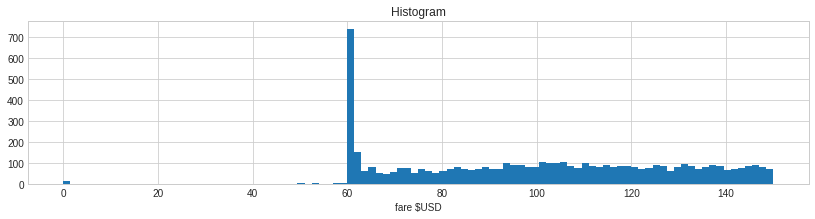

In [ ]:
train_df[train_df.fare<150].fare.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');


In [ ]:
train_df = pd.get_dummies(train_df, columns=['label'])
train_df = train_df.drop(['label_incorrect'],axis=1)


In [ ]:
# Get missing columns in the training test
missing_cols = set( train_df.columns ) - set( df_test.columns )
print(missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0
    
missing_cols =  set( df_test.columns ) - set( train_df.columns )
print(missing_cols)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    train_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[train_df.columns]
df_test = df_test.drop(columns=['label_correct'])

{'label_correct'}
set()


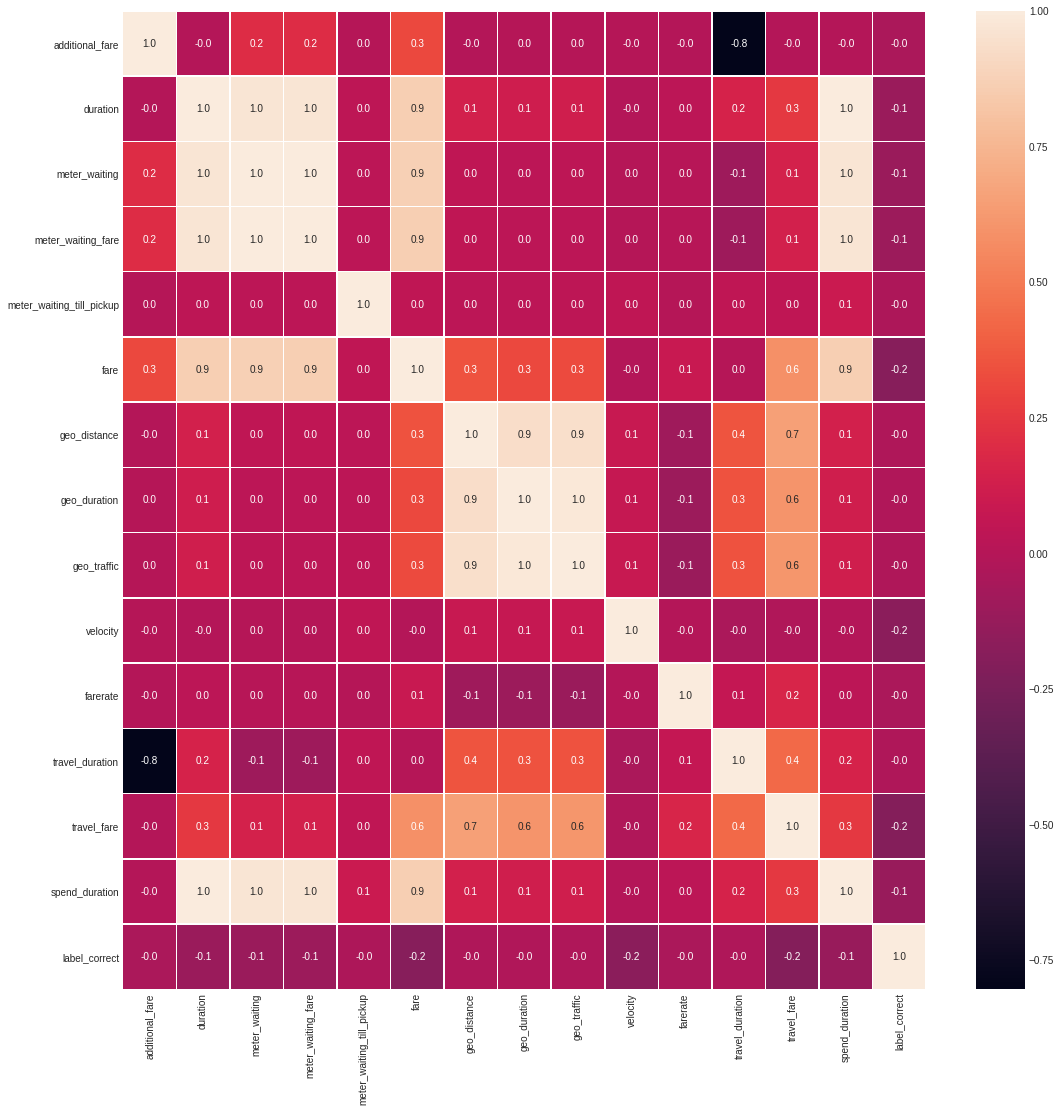

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

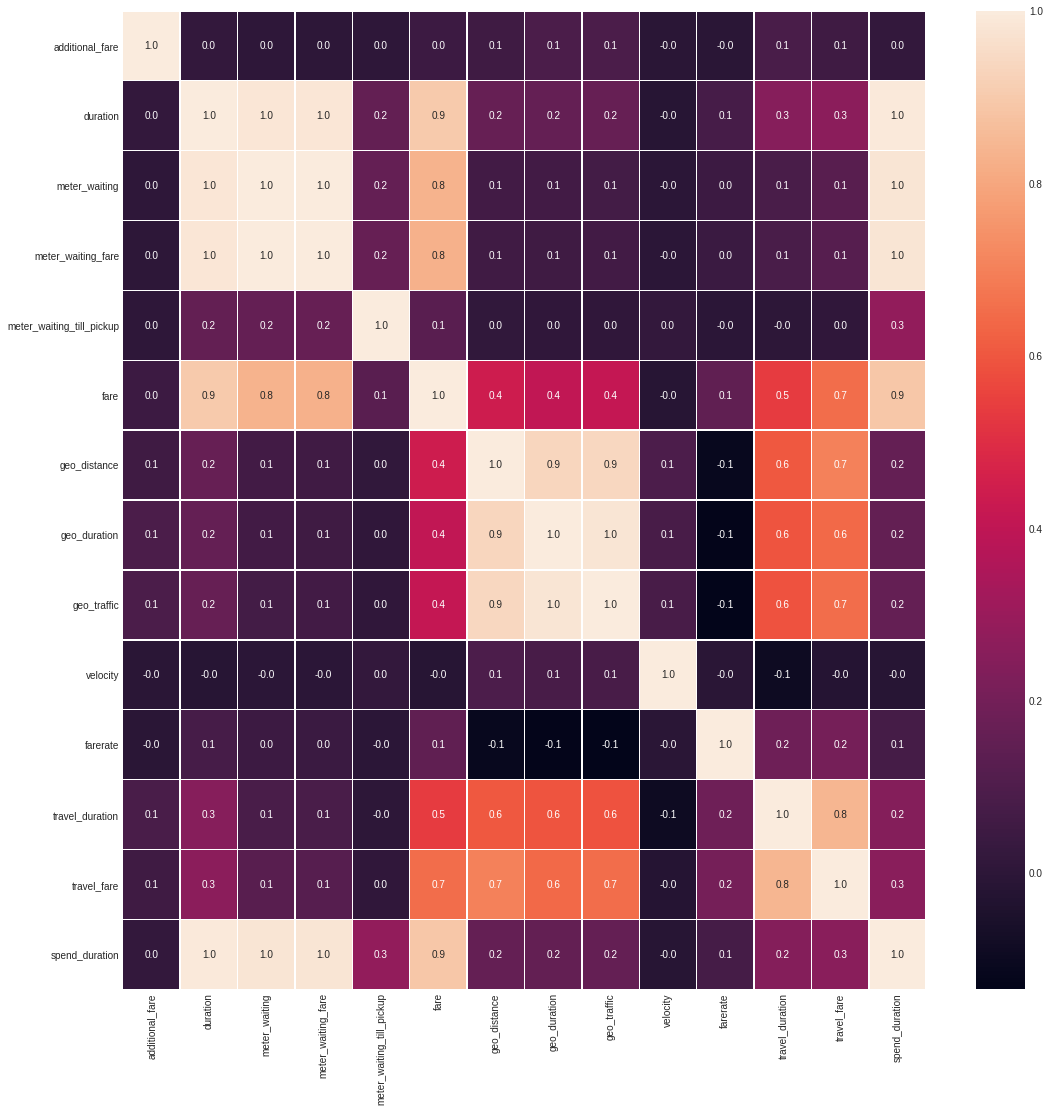

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_test.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


In [ ]:
train_df[train_df['label_correct']==0]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,geo_distance,geo_duration,geo_traffic,velocity,farerate,travel_duration,travel_fare,spend_duration,label_correct
tripid,,,,,,,,,,,,,,,
189135814,10.5,26.0,19.0,0.0000,73.0,694.37,18300.0,2203.0,1560.0,2614.285714,37.369945,7.0,683.8700,99.0,0
189140969,10.5,31.0,20.0,0.0000,130.0,235.59,5128.0,947.0,600.0,466.181818,43.894306,11.0,225.0900,161.0,0
189147041,10.5,1260.0,30.0,0.0000,9.0,111.21,1467.0,164.0,120.0,1.192683,68.650307,1230.0,100.7100,1269.0,0
189160756,10.5,358.0,66.0,0.0000,79.0,210.58,2702.0,407.0,420.0,9.253425,74.048853,292.0,200.0800,437.0,0
189161377,10.5,644.0,638.0,14.7968,108.0,113.71,1011.0,193.0,120.0,168.500000,87.451236,6.0,88.4132,752.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213639520,10.5,2532.0,2529.0,88.3762,142.0,250.05,4.0,60.0,60.0,1.333333,37793.450000,3.0,151.1738,2674.0,0
213658727,10.5,943.0,359.0,0.2312,90.0,111.04,5867.0,998.0,960.0,10.046233,17.097119,584.0,100.3088,1033.0,0
213689462,40.5,4310.0,1314.0,75.9492,469.0,902.02,12096.0,2030.0,1560.0,4.037383,64.944676,2996.0,785.5708,4779.0,0


In [ ]:
y = train_df['label_correct']
train = train_df.drop(columns=['label_correct'])
print(y.shape[0])
print(train_df.shape[0])


16967
16967


In [ ]:
df_test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,geo_distance,geo_duration,geo_traffic,velocity,farerate,travel_duration,travel_fare,spend_duration
tripid,,,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,289.27,8568.0,1302.0,1320.0,9.714286,32.250397,882,276.32140,1072
213286352,10.5,4249,20,0.00000,91,1912.70,63545.0,5020.0,4500.0,15.026011,29.934692,4229,1902.20000,4340
213293973,10.5,1552,255,2.65880,23,394.00,7333.0,1486.0,1080.0,5.653816,51.935252,1297,380.84120,1575
213294622,10.5,462,16,0.00000,198,154.32,3986.0,594.0,420.0,8.937220,36.081284,446,143.82000,660
213298687,10.5,814,392,12.36920,69,147.47,3036.0,508.0,360.0,7.194313,41.041107,422,124.60080,883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,388.48,6079.0,922.0,840.0,4.697836,58.092890,1294,353.14668,1726
222857785,10.5,1378,80,0.00000,125,379.85,11009.0,1815.0,1440.0,8.481510,33.549823,1298,369.35000,1503
222858416,10.5,418,56,3.28440,93,112.79,2288.0,424.0,360.0,6.320442,43.271678,362,99.00560,511


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=2,test_size=0.2)

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target ],eval_metric='auc')
        
    #Predict training set:    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    #Print model report:
    print("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("F1 Score : %.4g" % f1_score(dtrain[target].values, cross_val_predict(alg, train,y, cv=8),average='macro').mean())
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
predictors = [x for x in train_df.columns if x not in [target, IDcol]]



Model Report
Accuracy : 0.9671
F1 Score : 0.8384
AUC Score (Train): 0.969364


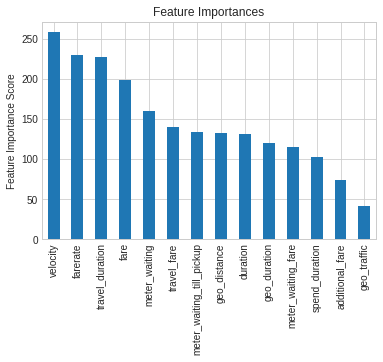

In [ ]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_df, predictors)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 4.94088278,  5.10043941,  5.04831519,  8.38043194,  8.29771891,
          7.87580318, 12.2387188 , 11.51187086, 11.13005748, 15.87487674,
         14.75804825, 11.90046234]),
  'mean_score_time': array([0.06271577, 0.05825706, 0.04717555, 0.07611718, 0.07315016,
         0.06116934, 0.09008436, 0.08610034, 0.09354253, 0.10039463,
         0.09438057, 0.0784483 ]),
  'mean_test_score': array([0.82865549, 0.82797618, 0.82605722, 0.84054   , 0.83939565,
         0.83780712, 0.83834318, 0.84081671, 0.84173232, 0.83879798,
         0.83688417, 0.83845542]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, Fa

In [ ]:
param_test2 = {
 'max_depth':[4,5,6,7,8,9],
 'min_child_weight':[5,6,7,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_df[predictors],train_df[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
param_test2b = {
 'min_child_weight':[3,4,5,6,7,8,9]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=6,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train_df[predictors],train_df[target])

In [ ]:
modelfit(gsearch2b.best_estimator_, train_df, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_df[predictors],train_df[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_df, predictors)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_df[predictors],train_df[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,85,5)],
 'colsample_bytree':[i/100.0 for i in range(65,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_df[predictors],train_df[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=6,
 min_child_weight=5, gamma=0.0, subsample=0.75, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='f1_macro',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_df[predictors],train_df[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=5,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train_df, predictors)
#0.8418

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
%%time
model_train = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=2,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

# (
#  learning_rate =0.01,
#  n_estimators=1000,
#  max_depth=9,
#  min_child_weight=2,
#  gamma=0,
#  subsample=0.9,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)


model_train.fit(x_train,y_train)

In [ ]:
%%time
score=cross_val_score(model_train,train,y,cv=10)
score

In [ ]:
print(score.mean())
#0.0.952966528057282
#0.9542040407044619

In [ ]:
y_pred = cross_val_predict(model_train, train,y, cv=10)

f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# 162 (143 29) 3060
# 174 (136 34) 3050
# 170 (162 29) 3033 with out geo_coo
# 166 (166 27) 3035 with geo_coo
# 154 (178 29) 3033 with SMOTE

In [ ]:
f1_score(y, y_pred, average='macro')

In [ ]:
xpt = model_train.predict(x_test)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(confusion_matrix(y_test, xpt), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# 162 (143 29) 3060
# 174 (136 34) 3050
# 170 (162 29) 3033 with out geo_coo
# 166 (166 27) 3035 with geo_coo
# 154 (178 29) 3033 with SMOTE

In [ ]:
f1_score(y_test, xpt, average='micro')
#

In [ ]:
model_train.score(x_test, y_test)
#0.9472598703594579

In [ ]:
train

In [ ]:
#############################

In [ ]:
%%time
model_sub = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=2,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_sub.fit(train,y)

In [ ]:
df_test.shape[0]*(1-0.97929)

In [ ]:
test_pred = model_sub.predict(df_test)
test_pred

In [ ]:
submission_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/sample_submission.csv", 
                            index_col="tripid")
submission_df

In [ ]:
submission_df['prediction'] = test_pred

submission_df.to_csv('my_submissiontu.csv', index=True)

In [ ]:
submission_df[submission_df['prediction']==0 ]